In [1]:
%load_ext autoreload
%autoreload 2
from awesome.run.awesome_config import AwesomeConfig
from awesome.run.awesome_runner import AwesomeRunner
from awesome.util.reflection import class_name
import os
import torch

from awesome.dataset.sisbosi_dataset import SISBOSIDataset, ConvexityDataset as SISBOSIConvexityDataset
from awesome.dataset.convexity_segmentation_dataset import ConvexitySegmentationDataset
from awesome.measures.awesome_loss import AwesomeLoss
from awesome.measures.regularizer_loss import RegularizerLoss
from awesome.model.convex_diffeomorphism_net import ConvexDiffeomorphismNet
from awesome.model.net import Net
import awesome
from awesome.util.path_tools import get_project_root_path
from awesome.util.logging import basic_config
import matplotlib.pyplot as plt

basic_config()

os.chdir(get_project_root_path()) # Beeing in the root directory of the project is important for the relative paths to work consistently

D:\projects\AWESOME\awesome\agent\torch_agent.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from typing import Literal
from awesome.dataset.awesome_dataset import AwesomeDataset
from awesome.dataset.fbms_sequence_dataset import FBMSSequenceDataset
from awesome.dataset.sisbosi_dataset import SISBOSIDataset, ConvexityDataset as SISBOSIConvexityDataset
from awesome.measures.awesome_image_loss_joint import AwesomeImageLossJoint
from awesome.measures.awesome_image_loss import AwesomeImageLoss
from awesome.measures.gradient_penalty_loss import GradientPenaltyLoss
from awesome.measures.fbms_joint_loss import FBMSJointLoss
from awesome.measures.regularizer_loss import RegularizerLoss
from awesome.model.cnn_net import CNNNet
from awesome.measures.tv import TV
from awesome.model.convex_net import ConvexNet
from awesome.model.unet import UNet
from awesome.measures.weighted_loss import WeightedLoss
from awesome.measures.se import SE
from awesome.measures.ae import AE
from awesome.measures.unaries_conversion_loss import UnariesConversionLoss

xytype = "edge"
dataset_kind = "train"
dataset = "bear01"
all_frames = True
subset = None #slice(0, 5)
segmentation_model_switch: Literal["original", "retrain", "retrain_xy"] = "original"


segmentation_model_state_dict_path = None
if segmentation_model_switch == "original":
    segmentation_model_state_dict_path = f"./data/checkpoints/labels_with_uncertainty_flownet2_based/model_{dataset}_unet.pth"
elif segmentation_model_switch == "retrain":
    segmentation_model_state_dict_path = f"./data/checkpoints/refit_unet_uncertainty/23_11_13/model_{dataset}_unet.pth"
elif segmentation_model_switch == "retrain_xy":
    segmentation_model_state_dict_path = f"./data/checkpoints/refit_spatial_unet_uncertainty/23_11_13/model_{dataset}_unet.pth"
else:
    raise ValueError(f"Unknown segmentation_model_switch: {segmentation_model_switch}")
image_channel_format = "bgr" if segmentation_model_switch == "original" else "rgb"

prior_criterion = UnariesConversionLoss(SE(reduction="mean"))

data_path = f"./data/local_datasets/FBMS-59/{dataset_kind}/{dataset}"

real_dataset = FBMSSequenceDataset(
                    dataset_path=data_path,
                    weak_labels_dir = "weak_labels/labels_with_uncertainty_flownet2_based",
                    processed_weak_labels_dir = "weak_labels/labels_with_uncertainty_flownet2_based/processed",
                    confidence_dir= "weak_labels/labels_with_uncertainty_flownet2_based/",
                    do_weak_label_preprocessing=True,
                    do_uncertainty_label_flip=True,
                    test_weak_label_integrity=False,
                    all_frames=True,
                )

cfg = AwesomeConfig(
        name_experiment=f"UNET+{dataset}+{xytype}+{segmentation_model_switch}+joint",
        dataset_type=class_name(AwesomeDataset),
        dataset_args={
            "dataset": real_dataset,
            "xytype": xytype,
            "feature_dir": f"{data_path}/Feat",
            "dimension": "3d", # 2d for fcnet
            "mode": "model_input",
            "model_input_requires_grad": False,
            "batch_size": 1,
            "split_ratio": 1,
            "shuffle_in_dataloader": False,
            "image_channel_format": image_channel_format,
            "do_image_blurring": True,
            "subset": subset
        },
        segmentation_model_type=class_name(UNet),
        segmentation_model_args={
            'in_chn': 4,
        },
        segmentation_training_mode='multi',
        segmentation_model_state_dict_path=segmentation_model_state_dict_path, # Path to the pretrained model
        use_segmentation_output_inversion=True,
        use_prior_model=True,
        prior_model_args=dict(
            n_hidden=130,
            n_hidden_layers=2,
            diffeo_args=dict(
                num_coupling=6,
                width=130,
                backbone="normal_block"
            ),
        ),
        prior_model_type=class_name(ConvexDiffeomorphismNet),
        loss_type=class_name(FBMSJointLoss),
        loss_args={
            "criterion": WeightedLoss(torch.nn.BCELoss(), mode="sssdms", noneclass=2),
            "penalty_criterion": prior_criterion.criterion, # Dont Threshold unaries
            "alpha": 1,
            "beta": 1,
        },
        use_extra_penalty_hook=False, # Panalty hook for the panalty term that models output should match
        #extra_penalty_after_n_epochs=1,
        #use_reduce_lr_in_extra_penalty_hook=False,
        use_lr_on_plateau_scheduler=False,
        use_binary_classification=True, 
        num_epochs=15,
        device="cuda",
        dtype=str(torch.float32),
        runs_path="./runs/fbms_local/unet/joint_testing/",
        optimizer_args={
            "lr": 0.0001,
            "betas": (0.9, 0.999),
            "eps": 1e-08,
            "amsgrad": False
        },
        use_progress_bar=True,
        semantic_soft_segmentation_code_dir="../siggraph/",
        semantic_soft_segmentation_model_checkpoint_dir="./data/sss_checkpoint/model",

        plot_indices_during_training_nth_epoch=5,
        compute_metrics_during_training_nth_epoch=5,

        compute_crf_with_metrics=True,
        compute_crf_after_training=True,
        compute_crf_after_pretraining=True,
        save_images_after_pretraining=True,
        include_unaries_when_saving=True,
        
        plot_indices_during_training=real_dataset.get_ground_truth_indices(),

        agent_args=dict(
            do_pretraining=True, 
            pretrain_only=False, # Do Fitting in pretrain mode only
            force_pretrain=False, 
            pretrain_state_path=f"./data/checkpoints/pretrain_states/23-11-13/model_{dataset}_unet_{xytype}_{segmentation_model_switch}_{prior_criterion.get_name()}.pth",
            pretrain_args=dict(
                lr=0.001,
                use_logger=True,
                use_step_logger=False,
                num_epochs=2000,
                proper_prior_fit_retrys=1,
                criterion=prior_criterion,
                do_pretrain_checkpoints=True,
                use_pretrain_checkpoints=True,
            )
        ),
        weight_decay_on_weight_norm_modules=5e-5,
        #output_folder="./runs/fbms_local/unet/TestUnet/",
    )
#cfg.save_to_file(f"./config/{cfg.name_experiment}.yaml", override=True, no_uuid=True)

In [3]:
runner = AwesomeRunner(cfg)
runner.build()
runner.store_config()

2024-01-12:19:16:45.878 INFO     [tensorboard.py:55] Tensorboard logger created at: runs\fbms_local\unet\joint_testing\UNET+bear01+edge+original+joint_24_01_12_19_16_45


'./runs/fbms_local/unet/joint_testing/UNET+bear01+edge+original+joint_24_01_12_19_16_45\\init_cfg_awesome_config.yaml'

In [4]:
#runner.config.num_epochs = 2000
runner.train()

2024-01-12:19:16:53.140 INFO     [torch_agent.py:571] Pretrain state loaded from ./data/checkpoints/pretrain_states/23-11-13/model_bear01_unet_edge_original_UCMSE.pth


Creating prior images...:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
runner.agent.open_folder()

In [14]:
from awesome.run.functions import get_result, split_model_result, plot_image_scribbles, plot_mask_labels
from awesome.util.temporary_property import TemporaryProperty

index = 0

model = runner.agent._get_model()
dataloader = runner.agent.training_dataset
model_gets_targets = runner.agent.model_gets_targets

figs = []
index = 0 #len(dataloader)

with TemporaryProperty(model, use_prior_sigmoid=False):
    res, ground_truth, img, fg, bg = get_result(model, dataloader, index, model_gets_targets=model_gets_targets)
    res_pred, res_prior_no_norm = model.split_model_output(res)[0]
    res = split_model_result(res, model, dataloader, img)

res_prior = res.get("prior", None)
res_pred = res["segmentation"]
boxes = res.get("boxes", None)
labels = res.get("labels", None)


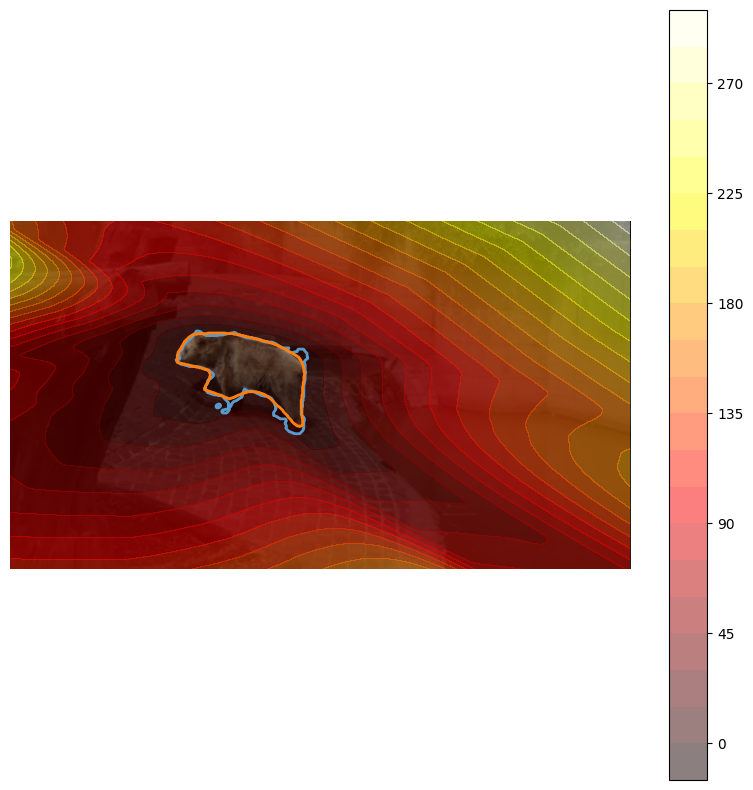

In [22]:
from awesome.run.functions import get_result, split_model_result, plot_image_scribbles, plot_mask_labels, plot_mask
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

orange = plt.get_cmap("tab10")(1)

plot_mask_labels(image=img, mask=1 - res_pred,
                     ax=ax,
                     )
plot_mask(image=img, mask=1 - res_prior,
                     ax=ax,
                     color=orange,
                     )
plt.contourf(res_prior_no_norm[0], alpha=0.5, cmap="hot", levels=20)

#plt.imshow(res_prior_no_norm[0], alpha=0.5, cmap="hot")
plt.colorbar()
fig


In [12]:
torch.unique(res_prior)

tensor([0., 1.])